In [14]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

In [3]:
ratings = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv")

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
users = len(ratings['userId'].unique())
movies = len(ratings['movieId'].unique())
print(users, movies)

671 9066


In [6]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [7]:
movieId_to_seqId = {}
seqId_to_movieId = {}

for sId, id in enumerate(ratings['movieId'].unique()) :
  seqId_to_movieId[sId] = id
  movieId_to_seqId[id] = sId

In [8]:
def return_movieId_to_seqId(row) :
  return movieId_to_seqId[row.movieId]

ratings['new_movieId'] = ratings.apply(return_movieId_to_seqId, axis=1)

In [9]:
ratings.describe()

,userId,movieId,rating,timestamp,new_movieId
count,100004.000000,100004.000000,100004.000000,1.000040e+05,100004.000000
mean,347.011310,12548.664363,3.543608,1.129639e+09,1660.778349
std,195.163838,26369.198969,1.058064,1.916858e+08,1893.955817
min,1.000000,1.000000,0.500000,7.896520e+08,0.000000
25%,182.000000,1028.000000,3.000000,9.658478e+08,327.000000
50%,367.000000,2406.500000,4.000000,1.110422e+09,873.000000
75%,520.000000,5418.000000,4.000000,1.296192e+09,2344.000000
max,671.000000,163949.000000,5.000000,1.476641e+09,9065.000000


In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [11]:
train.head()

,userId,movieId,rating,timestamp,new_movieId
37865,273,5816,4.5,1466946328,364
46342,339,2028,4.5,1446663181,113
64614,461,3895,0.5,1093224965,4626
41974,300,3578,4.5,1086010878,468
50236,369,292,3.0,847465462,48


In [12]:
test.head()

,userId,movieId,rating,timestamp,new_movieId
19090,128,1028,5.0,1049690908,165
99678,665,4736,1.0,1010197684,9064
18455,120,4002,3.0,1167420604,2763
35755,257,1274,4.0,1348544094,2190
66536,468,6440,4.0,1296191715,1333


In [15]:
movie_input = Input(shape=[1], name='Movies')

movie_embedding = Embedding(movies+1, 5, name='Embedded_Movies')(movie_input)
movie_final = Flatten(name='Flatten_Movies')(movie_embedding)

In [17]:
user_input = Input(shape=[1], name='Users')
user_embedding = Embedding(users+1, 5, name='Embedded_Users')(user_input)
user_final = Flatten(name='Flatten_Users')(user_embedding)

In [18]:
mult = Dot(name='Dot_Product', axes=1)([movie_final, user_final])

In [19]:
from keras.losses import mean_squared_error
from keras import backend as K

def root_mean_squared_error(y_true, y_pred) :
  return K.sqrt(mean_squared_error(y_true, y_pred))

model = Model([movie_input, user_input], mult)
model.compile(optimizer='adam', loss=root_mean_squared_error)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movies (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Users (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embedded_Movies (Embedding)     (None, 1, 5)         45335       Movies[0][0]                     
__________________________________________________________________________________________________
Embedded_Users (Embedding)      (None, 1, 5)         3360        Users[0][0]                      
______________________________________________________________________________________________

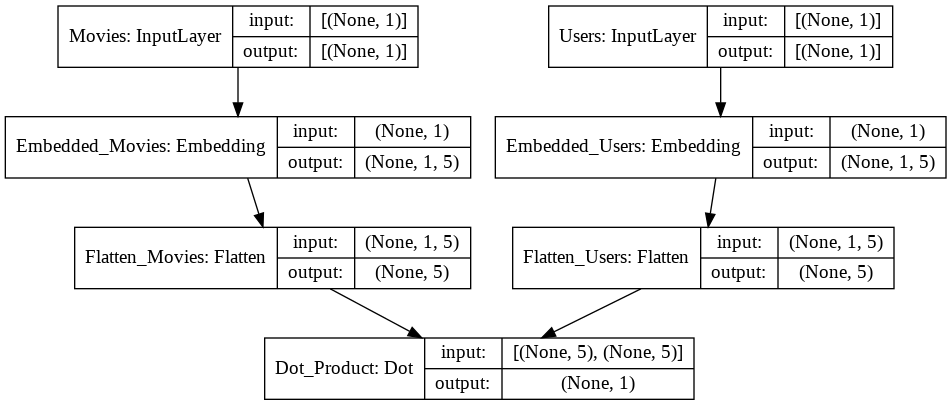

In [21]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/10
2501/2501 [==============================] - 5s 2ms/step - loss: 3.2985
Epoch 2/10
2501/2501 [==============================] - 4s 2ms/step - loss: 1.8860
Epoch 3/10
2501/2501 [==============================] - 5s 2ms/step - loss: 1.2453
Epoch 4/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.9896
Epoch 5/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.8679
Epoch 6/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.8002
Epoch 7/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.7581
Epoch 8/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.7289
Epoch 9/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.7081
Epoch 10/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.6927


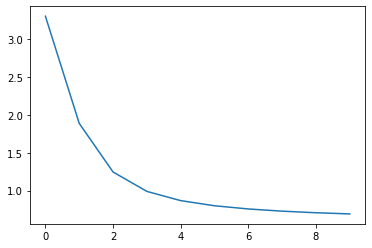

In [22]:
from keras.models import load_model

history = model.fit([train.new_movieId, train.userId], train.rating, epochs=10, verbose=1)

model.save('recommender_model.h5')

plt.plot(history.history['loss'])
plt.xlabel = ('Epochs')
plt.ylabel = ('Training_Error')

plt.show()

In [23]:
model.evaluate([test.new_movieId, test.userId], test.rating)

626/626 [==============================] - 1s 1ms/step - loss: 0.8109


0.8109461069107056

In [24]:
predictions = model.predict([test.new_movieId.head(8), test.userId.head(8)])

In [25]:
print(predictions)

[[ 4.890539  ]
 [-0.01031067]
 [ 3.4706728 ]
 [ 3.6973326 ]
 [ 3.2651215 ]
 [ 3.8935225 ]
 [ 3.7599697 ]
 [-0.06341225]]


In [26]:
for i in range(8) :
  print(predictions[i], test.rating.iloc[i])

[4.890539] 5.0
[-0.01031067] 1.0
[3.4706728] 3.0
[3.6973326] 4.0
[3.2651215] 4.0
[3.8935225] 5.0
[3.7599697] 5.0
[-0.06341225] 4.0
